# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 


## Import Packages

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
%matplotlib inline

## Calibrate Camera

In [2]:
# glob_name: calibration images path in glob format.
def calibrate_camera(glob_name) :
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(glob_name)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
            # Uncomment the next 2 lines to show the results
            #plt.figure()
            #plt.imshow(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, \
                                            gray.shape[::-1], None, None) 
    return mtx, dist

cam_mtx, cam_dist = calibrate_camera('camera_cal/calibration*.jpg')

## Perspective transform helpers

In [3]:
import math

# Uses mtx and dist from the cell above
def undistort_image(img):
    return cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)

# try distorting a couple of images.
cv2.imwrite("chess_undistorted.jpg", undistort_image(cv2.imread("chess_original.jpg")))
cv2.imwrite("road_undistorted.jpg", undistort_image(cv2.imread("road_original.jpg")))

def _region_of_interest(shape):
    offset = 120
    src_pts = np.float32([[shape[1]/13,shape[0]], [4*shape[1]/9 - 5, 2*shape[0]/3 - 20], \
        [5*shape[1]/9 + 5, 2*shape[0]/3 - 20], [12*shape[1]/13,shape[0]]])
    dst_pts = np.float32([[offset, shape[0]], [offset, 0], \
        [shape[1] - offset, 0], [shape[1] - offset, shape[0]]])
    
    return src_pts, dst_pts

def vertical_perspective(img):
    """
    Applies an image transform.
    
    Extracts a trapezoidal area right in front of the car, and transforms
    it to a rectangular area.
    """
    shape = img.shape

    src_pts, dst_pts = _region_of_interest(shape) 
    
    #cv2.polylines(img, np.int32([src_pts]), True, (255, 255, 255))

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    return cv2.warpPerspective(img, M, shape[1::-1])

def restore_perspective(img):
    shape = img.shape

    src_pts, dst_pts = _region_of_interest(shape) 

    #cv2.polylines(img, np.int32([src_pts]), True, (255, 255, 255))

    M = cv2.getPerspectiveTransform(dst_pts, src_pts)
    
    return cv2.warpPerspective(img, M, shape[1::-1])

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['mytest2.jpg',
 'mytest3.jpg',
 'mytest1.jpg',
 'test6.jpg',
 'test5.jpg',
 'test4.jpg',
 'test1.jpg',
 'test3.jpg',
 'test2.jpg',
 'straight_lines2.jpg',
 'straight_lines1.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `output_images` directory, and you can use the images in your writeup report.

In [5]:
def read_file(filename):
    return mpimg.imread(filename)

# Extract the yellow and white parts of the given image.
# img MUST be HSV.
def extract_lane_colors(img):
    # It's not an exact science here, just get sensible numbers.
    lower = np.array([15, 75, 100], dtype='uint8')
    upper = np.array([35, 255, 255], dtype='uint8')

    mask = cv2.inRange(img, lower, upper)
    yellow = cv2.bitwise_and(img, img, mask=mask)
    
    lower = np.array([0, 0, 180], dtype='uint8')
    upper = np.array([180, 30, 255], dtype='uint8')

    mask = cv2.inRange(img, lower, upper)
    white = cv2.bitwise_and(img, img, mask=mask)
    
    return cv2.bitwise_or(yellow, white)

# Extract all the edges based on a sobel filter, the HLS saturation
# and the HLS lighting value.
def get_edges(image, sobel_kernel=3, mag_thresh=(0, 255), \
              sat_thresh=(0, 255), light_thresh=(0, 255)):
    undist = undistort_image(image)

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    h, l, s = cv2.split(hls)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    sobel_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    scaled = np.uint8(255 * sobel_mag/np.max(sobel_mag))

    binary_mag = np.zeros_like(gray)
    binary_mag[(scaled > mag_thresh[0]) & (scaled < mag_thresh[1])] = 1
    
    binary_col = np.zeros_like(gray)
    binary_col[((s > sat_thresh[0]) & (s <= sat_thresh[1])) \
               | ((l > light_thresh[0]) & (l <= light_thresh[1]))] = 1

    return binary_col * binary_mag


## Sliding-window lane search

Code from the lesson.

In [6]:
# window settings

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):

    window_centroids = [] # Store the (left,right) window centroid positions per level
    centroid_confidence = [] # The number of data points found at the centroid
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_arr = np.convolve(window, l_sum)
    l_argmax = np.argmax(l_arr)
    l_conf = l_arr[l_argmax]
    l_center = image.shape[1] / 10
    if l_conf > 10:
        l_center = l_argmax - window_width/2
    
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_arr = np.convolve(window, r_sum)
    r_argmax = np.argmax(r_arr)
    r_conf = r_arr[r_argmax]
    r_center = 9 * image.shape[1] / 10
    if r_conf > 10:
        r_center = r_argmax - window_width/2 + int(image.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    centroid_confidence.append((l_conf, r_conf))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        
        l_arr = conv_signal[l_min_index:l_max_index]
        l_argmax = np.argmax(l_arr)
        l_conf = l_arr[l_argmax]
        if (l_conf > 5):
            l_center = l_argmax + l_min_index - offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        
        r_arr = conv_signal[r_min_index:r_max_index]
        r_argmax = np.argmax(r_arr)
        r_conf = r_arr[r_argmax]
        if (r_conf > 5):
            r_center = r_argmax + r_min_index - offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        centroid_confidence.append((l_conf, r_conf))

    return window_centroids, centroid_confidence

## Lane and LaneCollection

Define a class that represents a single lane, and another that represents a lane collection.

In [19]:
class Lane:
    def __init__(self):
        self.l_line = []  # Left line raw image
        self.r_line = []  # Right line raw image
        self.l_fit = np.array([0,0,0]) # Quadratic fit parameters
        self.r_fit = np.array([0,0,0])
        self.l_num_pts = 0 # The number of points that represent the line.
        self.r_num_pts = 0
        self.l_fit_valid = False # If true, the l_fit is valid
        self.r_fit_valid = False
    
    # Given an image, split it into left and right lines.
    def detect_lane_lines(self, warped):
        shape = warped.shape
        window_width = shape[1] // 25 # Lanes lines aren't expected to be wide
        window_height = shape[0] // 20 # Break image into 9 vertical layers since image height is 720
        margin = window_width # How much to slide left and right for searching

        window_centroids, centroid_confidence = find_window_centroids(warped, window_width, window_height, margin)

        # If we found any window centers draw a window over them.
        if len(window_centroids) > 0:

            # Points used to draw all the left and right windows
            l_points = np.zeros_like(warped)
            r_points = np.zeros_like(warped)

            # Go through each level and draw the windows 	
            for level in range(0,len(window_centroids)):
                # Window_mask is a function to draw window areas
                l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
                r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
                # Add graphic points from window mask here to total pixels found 
                l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
                r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255


            self.l_line = np.zeros_like(warped)
            self.l_line[(warped > 0) & (l_points > 0)] = 1
            self.r_line = np.zeros_like(warped)
            self.r_line[(warped > 0) & (r_points > 0)] = 1

        # If no window centers found, just display orginal road image
        else:
            self.l_line = warped
            self.r_line = warped
            l_points = np.zeros_like(warped)
            r_points = np.zeros_like(warped)

        assert(self.l_line.shape == self.r_line.shape)
        return self.l_line, self.r_line, r_points+l_points
    
    # Fit quadratic polynomials over the left and the right lane lines
    def extrapolate_lane(self):
        shape = self.l_line.shape
        
        # Make sure the left and right lines look compatible.
        assert(shape == self.r_line.shape)

        # Get the points that make up the left line.
        (y_pts, x_pts) = np.nonzero(self.l_line)
        self.l_num_pts = x_pts.size
        assert(y_pts.size == self.l_num_pts)
        # Fit a quadratic function.
        if self.l_num_pts > 0:
            self.l_fit = np.polyfit(y_pts, x_pts, 2)
            self.l_fit_valid = True

        # Do the same thing for the right line.
        (y_pts, x_pts) = np.nonzero(self.r_line)
        self.r_num_pts = x_pts.size
        assert(y_pts.size == self.r_num_pts)
        if self.r_num_pts > 0:
            self.r_fit = np.polyfit(y_pts, x_pts, 2)
            self.r_fit_valid = True
            
        return self.l_fit, self.r_fit

# Mainly used to take the average of a number of lanes.
class LaneCollection:
    def __init__(self, capacity=5):
        self.lanes = []
        self.capacity = capacity
#         self.l_avg_fit = np.array([0,0,0])
#         self.r_avg_fit = np.array([0,0,0])
#         self.l_avg_valid = False
#         self.r_avg_valid = False
        
    def _get_fit_average(self):
        left_arr = []
        right_arr = []
        for lane in self.lanes:
            if lane.l_fit_valid:
                left_arr.append(lane.l_fit)
            if lane.r_fit_valid:
                right_arr.append(lane.r_fit)
                
        return  np.average(np.array(left_arr), 0), \
                np.average(np.array(right_arr), 0)
        
    # Code from lesson (using hint).
    def _get_radius(self, fit, y_eval):
        # Define conversions in x and y from pixels space to meters
        ym = 30/720 # meters per pixel in y dimension
        xm = 3.7/700 # meters per pixel in x dimension

        vals = [xm / (ym ** 2) * fit[0], xm / ym * fit[1], fit[2]]
        # Calculate the new radii of curvature
        curve = ((1 + (2*vals[0]*y_eval*ym + vals[1])**2)**1.5) / np.absolute(2*vals[0])
                
        return np.average(curve)
    
    # Get the distance of the fit line from the center (-ve means to the left)
    def _get_dist_from_center(self, fit, shape):
        base_y = shape[0] * 1.0
        base_x = fit[0]*base_y**2 + fit[1]*base_y + fit[2]
        
        return ((shape[1] / 2.0) - base_x) * 3.7/700
    
    # Draws out the lane using input from the last 'capacity' lanes.
    def plot_lane(self, new_lane):
        shape = new_lane.l_line.shape
        
        # Generate y values to plot against.
        y_plot = np.arange(shape[0], step=50)

        l_updated = True
        r_updated = True
        l_x_plot = None
        r_x_plot = None

        confidence_threshold = 700
        
        # If we're not really confident about the fit, take a hint from the other lane.
        if (new_lane.l_num_pts < confidence_threshold and new_lane.r_num_pts > confidence_threshold):
            print("left lane not confident enough", new_lane.l_num_pts)
            new_lane.l_fit[0] = (new_lane.l_fit[0] + new_lane.r_fit[0]) / 2
            #new_lane.l_fit[1] = (new_lane.l_fit[1] + new_lane.r_fit[1]) / 2 # FIXME: questionable
            l_updated = False
            
        ## Same thing for the right lane.
        if (new_lane.r_num_pts < confidence_threshold and new_lane.l_num_pts > confidence_threshold):
            print("right lane not confident enough", new_lane.r_num_pts)
            new_lane.r_fit[0] = (new_lane.l_fit[0] + new_lane.r_fit[0]) / 2
            #new_lane.r_fit[1] = (new_lane.l_fit[1] + new_lane.r_fit[1]) / 2 # FIXME: questionable
            r_updated = False   
            
        # Add the new lane to our lane list.
        self.lanes.append(new_lane)
        if len(self.lanes) > self.capacity:
            self.lanes.pop(0)
            
        left_fit, right_fit = self._get_fit_average()    
        
        # Generate the points. Constrain the image to the left side of the image.
        l_x_plot = []
        if (np.isscalar(left_fit) == False):
            l_x_plot = np.maximum(np.minimum(left_fit[0]*y_plot**2 + left_fit[1]*y_plot \
                                         + left_fit[2],  3*shape[1]/4), 0)
            l_x_plot = l_x_plot.astype(int)
            
        else:
            return np.zeros((shape[0], shape[1], 3), np.uint8)

        # Generate the points. Constrain the image to the right side of the image.
        if (np.isscalar(right_fit) == False):
            r_x_plot = np.maximum(np.minimum(right_fit[0]*y_plot**2 + right_fit[1]*y_plot \
                                         + right_fit[2], shape[1]), shape[1]/4)
            r_x_plot = r_x_plot.astype(int)

        else:
            return np.zeros((shape[0], shape[1], 3), np.uint8)

        curv_rad = (self._get_radius(left_fit, y_plot) + self._get_radius(right_fit, y_plot)) / 2
        
        # Calculate the distance from the center.
        l_dist = self._get_dist_from_center(left_fit, shape)
        r_dist = self._get_dist_from_center(right_fit, shape)
        
        dist = (l_dist + r_dist) / 2.0
        
        # Draw the output
        output = np.zeros((shape[0], shape[1], 3), np.uint8)

        if (l_x_plot is None or r_x_plot is None): 
            return output

        l_pts = []
        for y, x in zip(y_plot, l_x_plot):
            l_pts.append((x,y))  
        cv2.polylines(output, [np.array(l_pts)], False, (50, 50, 255), thickness=10)

        r_pts = []
        for y, x in zip(y_plot, r_x_plot):
            r_pts.append((x,y))  
        cv2.polylines(output, [np.array(r_pts)], False, (50, 50, 255), thickness=10)
        r_pts = np.flipud(r_pts)

        fill_color = [50, 255, 50]
        if r_updated == False and l_updated == False:
            fill_color = [255, 0, 0]
        elif r_updated == False or l_updated == False:
            fill_color = [200, 50, 50]

        cv2.fillPoly(output, [np.concatenate((l_pts, r_pts))], color=fill_color)

        return output, curv_rad, dist

    
     

## Single Image Pipline

In [20]:
def process_still_image(raw):
    hsv = cv2.cvtColor(raw, cv2.COLOR_RGB2HSV)
    
    colors = extract_lane_colors(hsv)
    colors = cv2.cvtColor(colors, cv2.COLOR_HSV2RGB)
    edges = get_edges(colors, sobel_kernel=13, mag_thresh=(30, 150), \
                      sat_thresh=(65, 255), light_thresh=(200, 255))
    warped = vertical_perspective(edges)

    # These lanes are not related, create a new collection everytime.
    lanes = LaneCollection()
    lane = Lane()
    l_lane, r_lane, _ = lane.detect_lane_lines(warped)
    lane.extrapolate_lane()
    
    lane_trace, curv_rad, dist = lanes.plot_lane(lane)
    
    out = restore_perspective(lane_trace)
    
    cv2.putText(raw, "Curvature radius %.2f m" % (curv_rad), (40, 50), \
                cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(raw, "Distance from center %.2f m" % (dist), (40, 100), \
                cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255,255,255), 2, cv2.LINE_AA)
      

    out = cv2.addWeighted(raw, 1, out, 0.5, 0.0)
    
    return colors, edges, warped, l_lane+r_lane, lane_trace, out

# Run on the test images

The time has come! Start by detecting lanes on still images.

/Users/FMZ/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


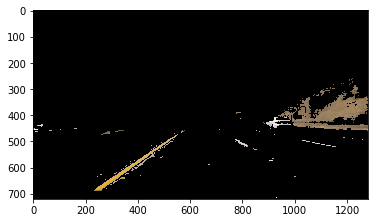

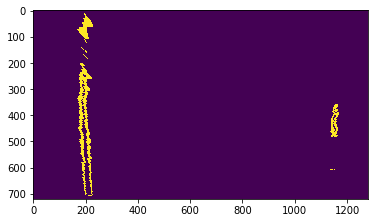

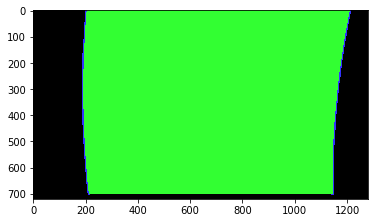

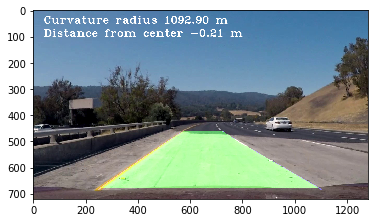

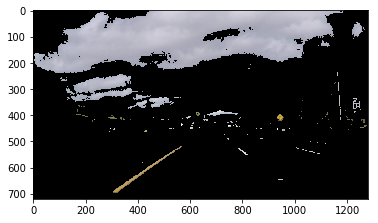

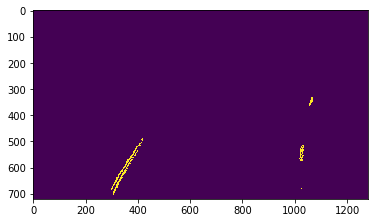

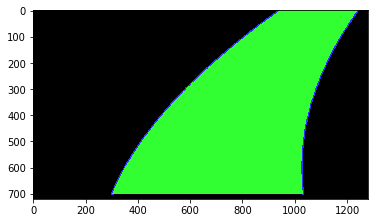

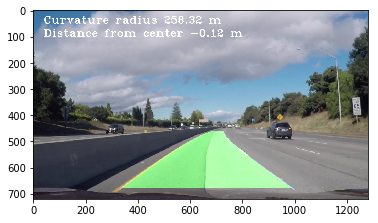

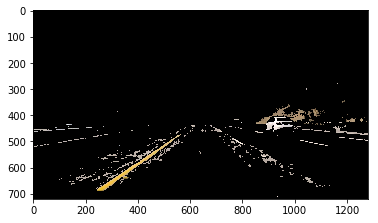

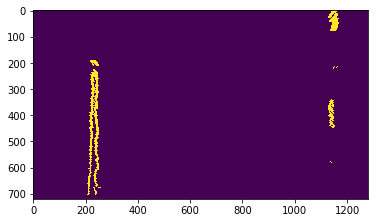

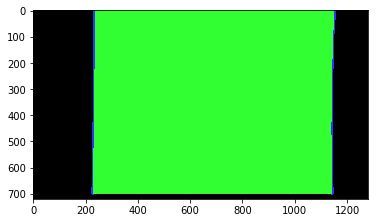

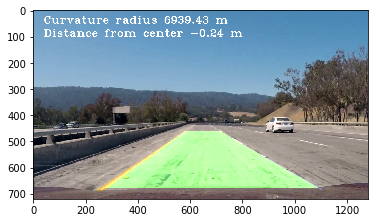

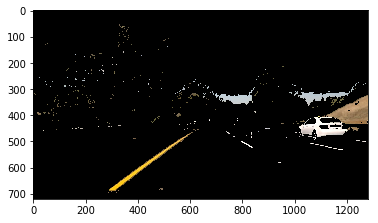

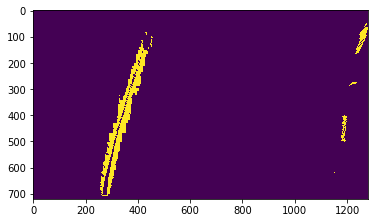

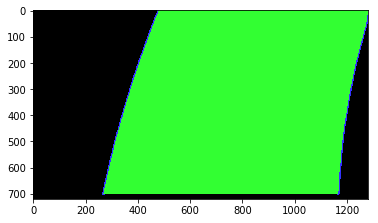

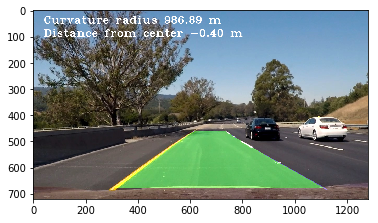

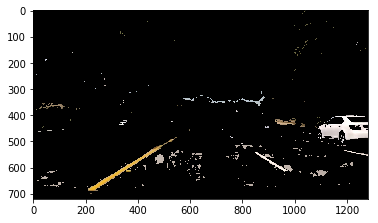

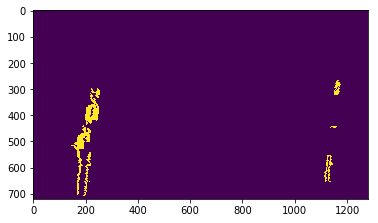

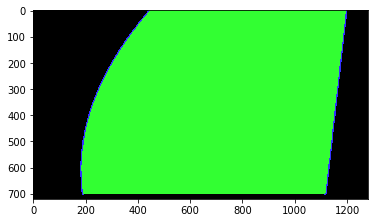

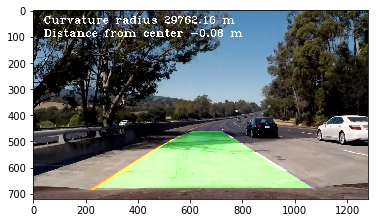

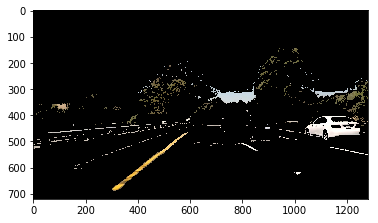

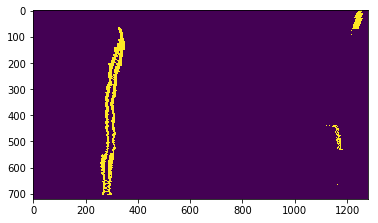

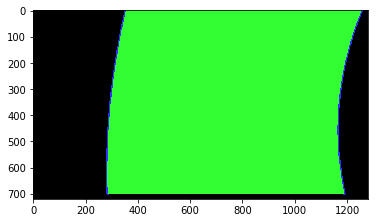

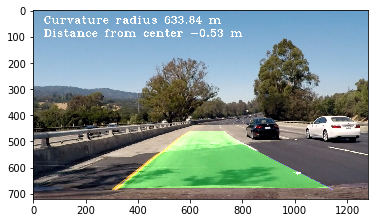

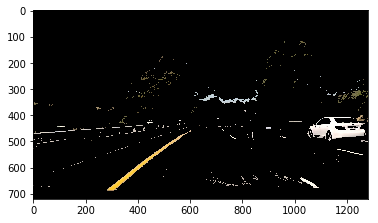

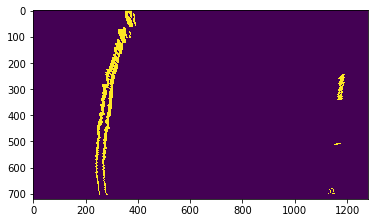

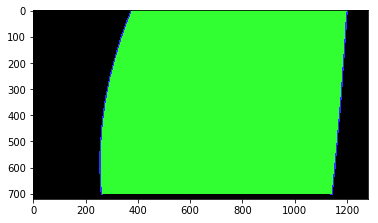

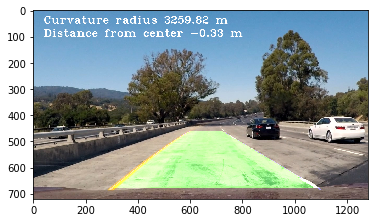

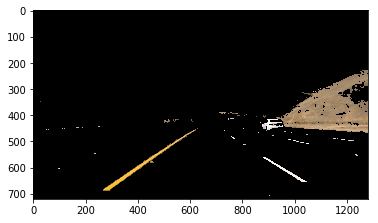

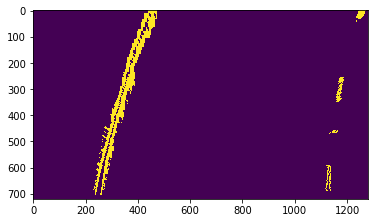

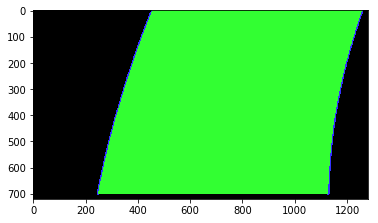

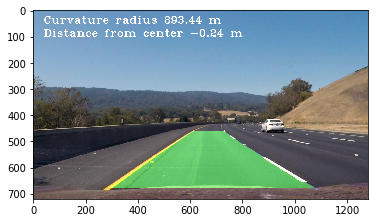

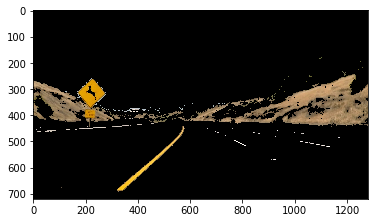

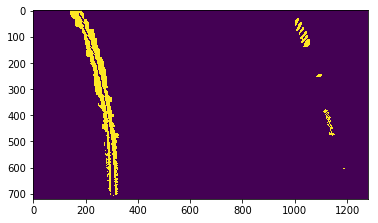

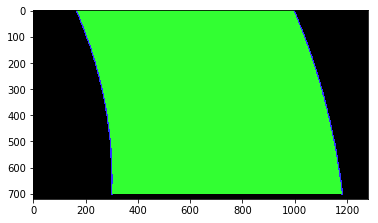

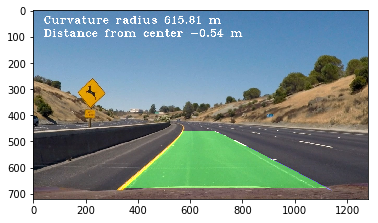

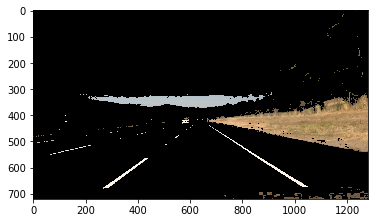

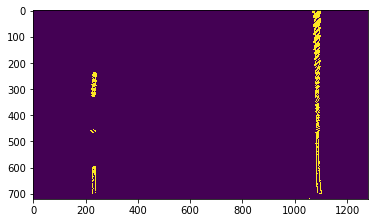

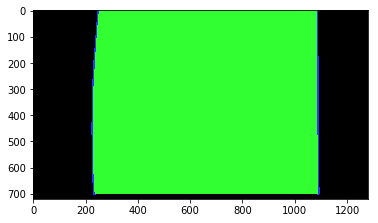

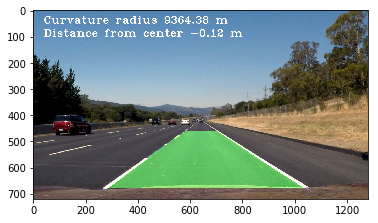

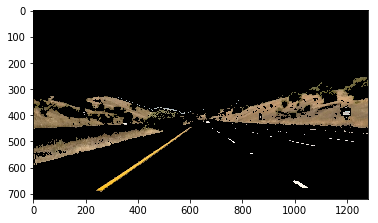

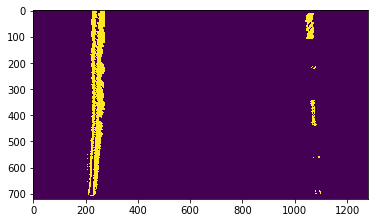

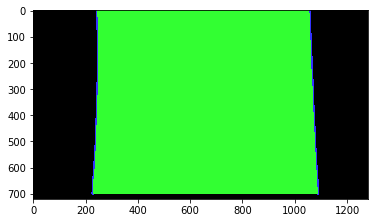

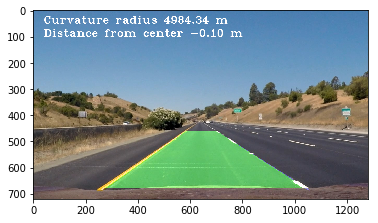

In [21]:
dir = "test_images/"
outdir = "output_images/"
plt.close('all')

for file in os.listdir(dir):
    
    raw = read_file(dir + file)  
    c, e, w, l, lt, o = process_still_image(raw)
    
    cv2.imwrite(outdir + file, cv2.cvtColor(o, cv2.COLOR_RGB2BGR))
    
    if file == 'mytest1.jpg':
        dumpdir = "dump/"
        #cv2.imwrite(dumpdir + "vertical_" + file, cv2.cvtColor(vertical_perspective(raw), cv2.COLOR_RGB2BGR))
        #cv2.imwrite(dumpdir + "horizontal_" + file, cv2.cvtColor(raw, cv2.COLOR_RGB2BGR))
        cv2.imwrite(dumpdir + "colors_" + file, cv2.cvtColor(c, cv2.COLOR_RGB2BGR))
        cv2.imwrite(dumpdir + "edges_" + file, e * 255)
        cv2.imwrite(dumpdir + "warped_" + file, w * 255)
        cv2.imwrite(dumpdir + "lanes_" + file, l * 255)
        cv2.imwrite(dumpdir + "traced_" + file, cv2.cvtColor(lt, cv2.COLOR_RGB2BGR))   

    
    plt.figure()
    plt.imshow(c)
    plt.figure()
    plt.imshow(l)
    plt.figure()
    plt.imshow(lt)
    plt.figure()
    plt.imshow(o)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!


In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Video image pipeline

In [26]:
vid_lanes = LaneCollection()
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    colors = extract_lane_colors(hsv)
    colors = cv2.cvtColor(colors, cv2.COLOR_HSV2RGB)
    edges = get_edges(colors, sobel_kernel=13, mag_thresh=(30, 150), \
                      sat_thresh=(65, 255), light_thresh=(200, 255))
    warped = vertical_perspective(edges)

    lane = Lane()
    l_lane, r_lane, _ = lane.detect_lane_lines(warped)
    lane.extrapolate_lane()
    
    lane_trace, curv_rad, dist = vid_lanes.plot_lane(lane)
    
    out = restore_perspective(lane_trace)
    
    cv2.putText(image, "Curvature radius %.2f m" % (curv_rad), (40, 50), \
                cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255,255,255), 2, cv2.LINE_AA)
    
    # A negative number means to the left.
    cv2.putText(image, "Distance from center %.2f m" % (dist), (40, 100), \
                cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (255,255,255), 2, cv2.LINE_AA)
    
    out = restore_perspective(lane_trace)
    
    return cv2.addWeighted(image, 1, out, 0.5, 0.0)
    

## Run on a Video.

In [ ]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 82%|████████▏ | 1038/1261 [05:52<01:14,  3.00it/s]

right lane not confident enough 610


 83%|████████▎ | 1041/1261 [05:53<01:14,  2.97it/s]

right lane not confident enough 462


 83%|████████▎ | 1044/1261 [05:54<01:11,  3.02it/s]

right lane not confident enough 467


 83%|████████▎ | 1045/1261 [05:54<01:12,  2.98it/s]

right lane not confident enough 412


 85%|████████▌ | 1074/1261 [06:04<01:02,  2.99it/s]

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
#for file in os.lisdir(out_dir) :
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))